- Satheesh D M

- MA24M023

- Task 4 - HED

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision.models as models
import logging
import os
import csv
import numpy as np
import random
import torch.nn.functional as F
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Seed setting function
def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module on MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # For MPS (Apple Silicon)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
        print("Seed set for MPS.")
    
    torch.use_deterministic_algorithms(True, warn_only=True)
        
    print(f"Seed set to: {seed}")

# Example Usage
set_seed(42)

Seed set for MPS.
Seed set to: 42


In [ ]:
# HED (Holistically-Nested Edge Detection) model class
# This class implements the HED model using a VGG16 backbone.
class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()

        # Load VGG16 as base network
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        features = list(vgg16.features.children())

        # Encoder (VGG16 backbone, WITHOUT last maxpool)
        self.conv1 = nn.Sequential(*features[:5])   
        self.conv2 = nn.Sequential(*features[5:10]) 
        self.conv3 = nn.Sequential(*features[10:17])
        self.conv4 = nn.Sequential(*features[17:24])
        self.conv5 = nn.Sequential(*features[24:29])

        # Side output layers (1x1 conv to get single-channel logits)
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)

        # Learnable fusion weights
        self.weights = nn.Parameter(torch.ones(5, dtype=torch.float32))

    def forward(self, x):
        img_size = x.shape[2:]

        # Forward pass through VGG16 layers
        c1 = self.conv1(x)  
        c2 = self.conv2(c1)  
        c3 = self.conv3(c2)  
        c4 = self.conv4(c3)  
        c5 = self.conv5(c4)  

        # Compute side outputs (raw logits)
        s1 = self.side1(c1)
        s2 = self.side2(c2)
        s3 = self.side3(c3)
        s4 = self.side4(c4)
        s5 = self.side5(c5)

        # Upsample side outputs to match input size
        s1 = F.interpolate(s1, size=img_size, mode="bilinear", align_corners=True)
        s2 = F.interpolate(s2, size=img_size, mode="bilinear", align_corners=True)
        s3 = F.interpolate(s3, size=img_size, mode="bilinear", align_corners=True)
        s4 = F.interpolate(s4, size=img_size, mode="bilinear", align_corners=True)
        s5 = F.interpolate(s5, size=img_size, mode="bilinear", align_corners=True)

        # Normalize the weights using softmax (to ensure non-negative weights)
        normalized_weights = F.softmax(self.weights, dim=0)

        # Final fused output using learnable weighted sum
        fused = sum(w * s for w, s in zip(normalized_weights, [s1, s2, s3, s4, s5]))

        return s1, s2, s3, s4, s5, fused

In [ ]:
# Balanced BCE with logits loss function
# This loss function is designed to handle class imbalance in binary classification tasks.
class BalancedBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(BalancedBCEWithLogitsLoss, self).__init__()

    def forward(self, pred, target):
        # Class balancing
        pos_count = torch.sum(target)
        neg_count = target.numel() - pos_count
        beta = neg_count / (pos_count + neg_count + 1e-6)

        weights = beta * target + (1 - beta) * (1 - target) + 1e-4
        loss = F.binary_cross_entropy_with_logits(pred, target, weight=weights)

        return loss

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100,
                        save_path='checkpoints', model_filename='model.pth', csv_filename='losses.csv',
                        unfreeze_epoch=20, clip_value=1.0):
    
    # Device Configuration
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Logging Configuration
    logging.basicConfig(filename='training.log', level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s')
    os.makedirs(save_path, exist_ok=True)

    # CSV Logging
    csv_path = os.path.join(save_path, csv_filename)
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss", "LR"])

    # Freeze Encoder Initially
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.conv2.parameters():
        param.requires_grad = False

    logging.info(f"Encoder frozen until epoch {unfreeze_epoch}")

    for epoch in range(num_epochs):
        
        # Unfreeze Encoder
        if epoch == unfreeze_epoch:
            for param in model.conv1.parameters():
                param.requires_grad = True
            for param in model.conv2.parameters():
                param.requires_grad = True
            logging.info(f"Encoder unfrozen at epoch {epoch+1}")

        # Training Phase
        model.train()
        epoch_loss = 0
        for images, edges in train_loader:
            images, edges = images.to(device), edges.to(device)

            optimizer.zero_grad()
            side_outputs = model(images)
            loss = sum(0.1 * criterion(out, edges) for out in side_outputs[:-1]) + 0.5 * criterion(side_outputs[-1], edges)
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        
        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, edges in val_loader:
                images, edges = images.to(device), edges.to(device)
                side_outputs = model(images)
                loss = sum(0.1 * criterion(out, edges) for out in side_outputs[:-1]) + 0.5 * criterion(side_outputs[-1], edges)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Logging
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, train_loss, val_loss])
        
        log_msg = (f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, '
                   f'Validation Loss: {val_loss}')
        logging.info(log_msg)
        print(log_msg)

    logging.info("Training completed.")
    return train_loss, val_loss


In [ ]:
# Dataloader for BSDS500 dataset
class BSDS500(Dataset):
    def __init__(self, image_dir, edge_dir, transform=None, edge_transform=None):
        """
        Custom dataloader for BSDS500 edge detection dataset using JPG ground truth.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            edge_dir (str): Path to corresponding edge ground truth directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.edge_transform = edge_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load Ground Truth Edge Image
        edge_path = os.path.join(self.edge_dir, img_name)
        edge_image = Image.open(edge_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.edge_transform:
            edge_image = self.edge_transform(edge_image)

        return image, edge_image

# Separate transforms
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

edge_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
train_dataset = BSDS500(image_dir='archive/images/train', edge_dir='archive/ground_truth_boundaries/train',
                         transform=vgg_transform, edge_transform=edge_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, generator=g)

val_dataset = BSDS500(image_dir='archive/images/val', edge_dir='archive/ground_truth_boundaries/val',
                       transform=vgg_transform, edge_transform=edge_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0, generator=g)


In [8]:
import torch.optim as optim
# Initialize model, criterion, and optimizer
model = HED()
criterion = BalancedBCEWithLogitsLoss()
lrate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lrate)

# Train and Validate
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, unfreeze_epoch=0)


Epoch [1/100], Train Loss: 0.024279602158528108, Validation Loss: 0.02119336597621441
Epoch [2/100], Train Loss: 0.021187837307269756, Validation Loss: 0.019885005839169027
Epoch [3/100], Train Loss: 0.020111691779815234, Validation Loss: 0.019289359785616397
Epoch [4/100], Train Loss: 0.019603514614013526, Validation Loss: 0.01882300157099962
Epoch [5/100], Train Loss: 0.01890871351441512, Validation Loss: 0.01844381056725979
Epoch [6/100], Train Loss: 0.018868174547186263, Validation Loss: 0.01813564945012331
Epoch [7/100], Train Loss: 0.018163534239507638, Validation Loss: 0.017873233407735823
Epoch [8/100], Train Loss: 0.01803696470764967, Validation Loss: 0.017659873701632023
Epoch [9/100], Train Loss: 0.017649224887673672, Validation Loss: 0.017505216635763644
Epoch [10/100], Train Loss: 0.01742118768967115, Validation Loss: 0.017359039336442946
Epoch [11/100], Train Loss: 0.017302318404500302, Validation Loss: 0.017249102368950844
Epoch [12/100], Train Loss: 0.017161480151116848

In [12]:
test_dataset = BSDS500(image_dir='archive/images/test', edge_dir='archive/ground_truth_boundaries/test',
                        transform=vgg_transform, edge_transform=edge_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False) 

In [ ]:
# Function to plot results

def plot_results(model, dataloader, threshold=0.25, device='cpu', num_batches=2):
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for images, edges in dataloader:
            images = images.to(device)
            edges = edges.unsqueeze(1).to(device)

            side_outputs = model(images)  # Model returns multiple outputs
            probs = [torch.sigmoid(out) for out in side_outputs]  # Convert each output to probabilities
            predictions = [(p > threshold).float() for p in probs]  # Apply threshold

            for i in range(len(images)):
                num_outputs = len(predictions)

                plt.figure(figsize=(4 * (num_outputs + 2), 4))  # Dynamic figure size

                # Plot Input Image
                plt.subplot(1, num_outputs + 2, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")
                plt.axis('off')

                # Plot Ground Truth
                plt.subplot(1, num_outputs + 2, 2)
                plt.imshow(edges[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth")
                plt.axis('off')

                # Plot Side Outputs
                for j in range(num_outputs):
                    plt.subplot(1, num_outputs + 2, j + 3)
                    plt.imshow(predictions[j][i].cpu().squeeze(), cmap='gray')
                    if j == num_outputs - 1:
                        plt.title(f"Fused Output (Threshold={threshold})")
                    else:
                        plt.title(f"Side Output {j + 1}")
                    plt.axis('off')

                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break


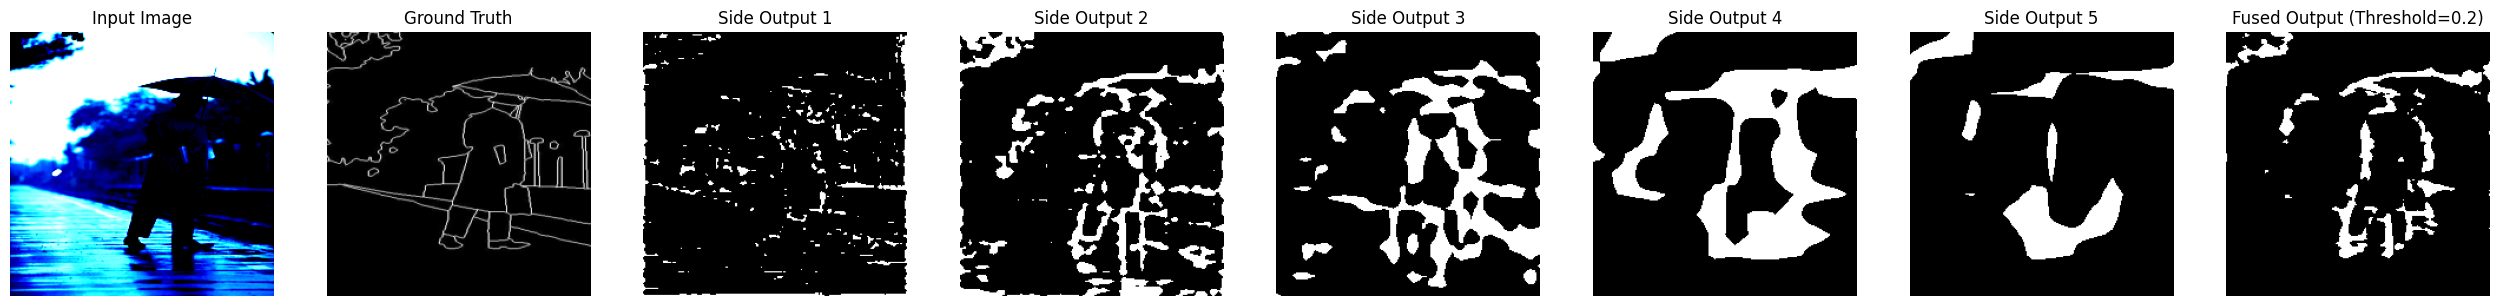

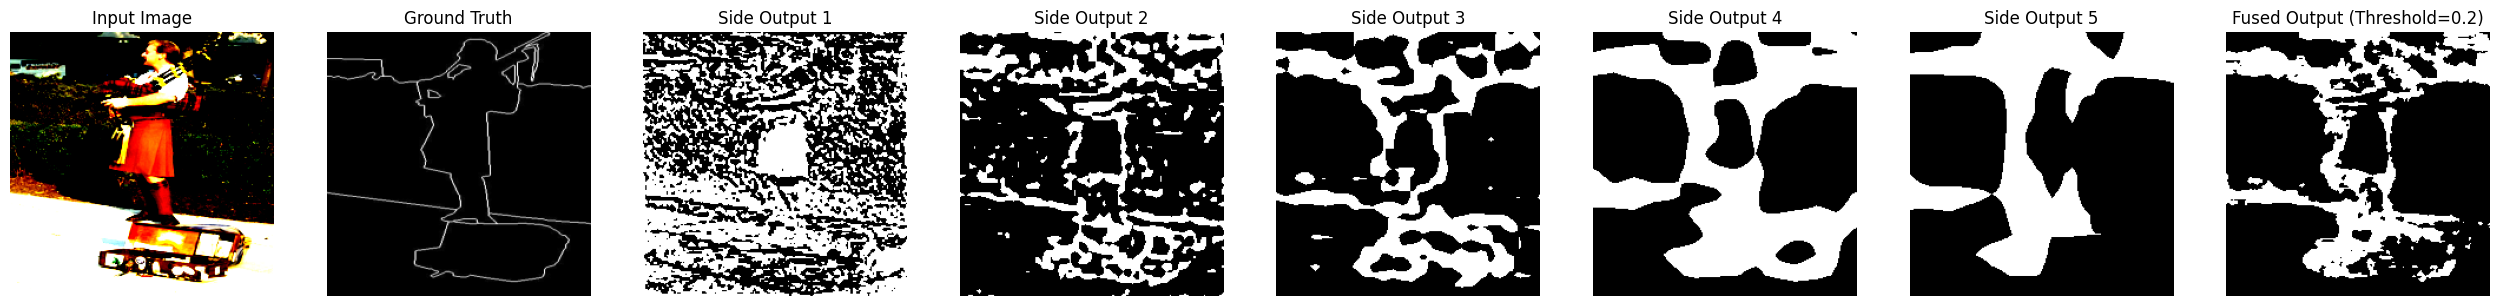

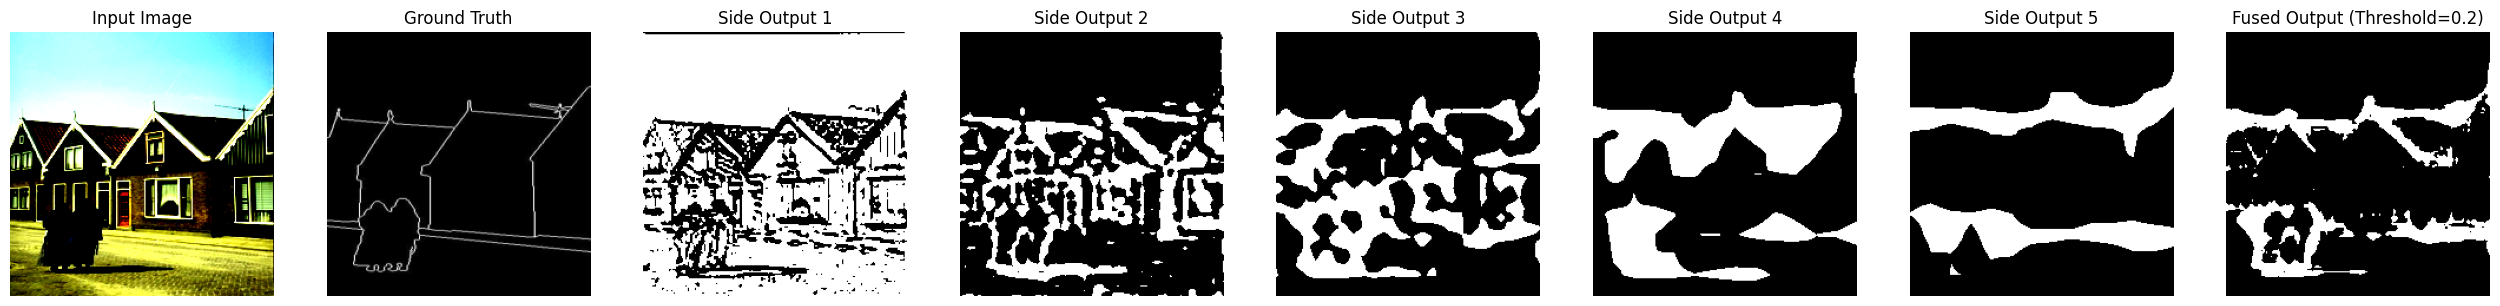

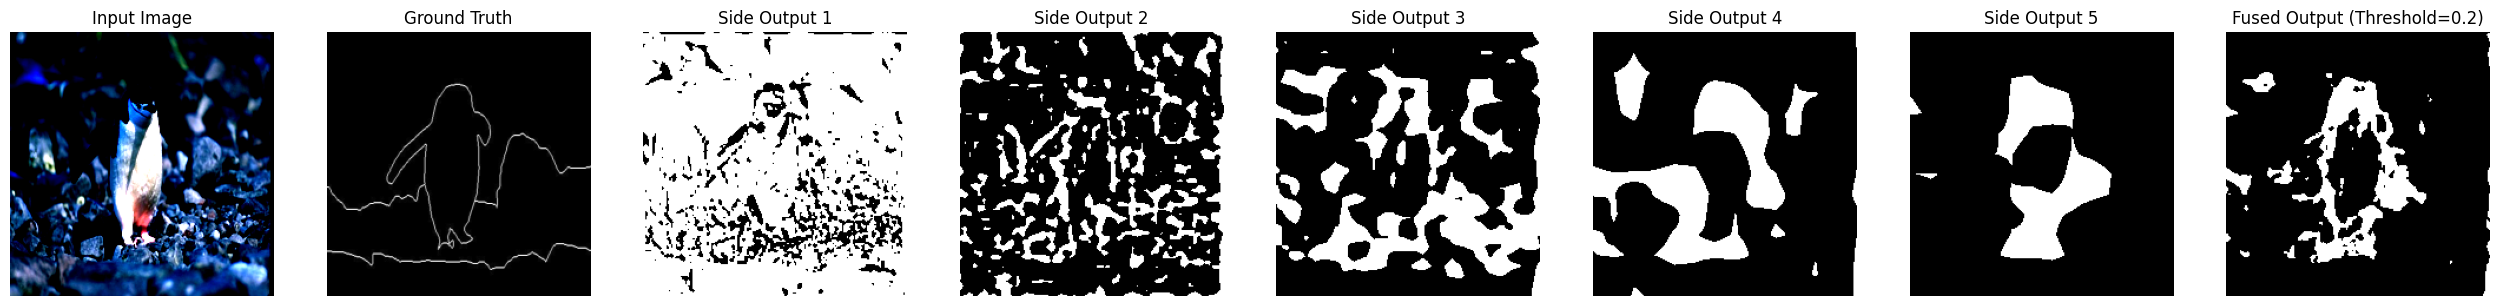

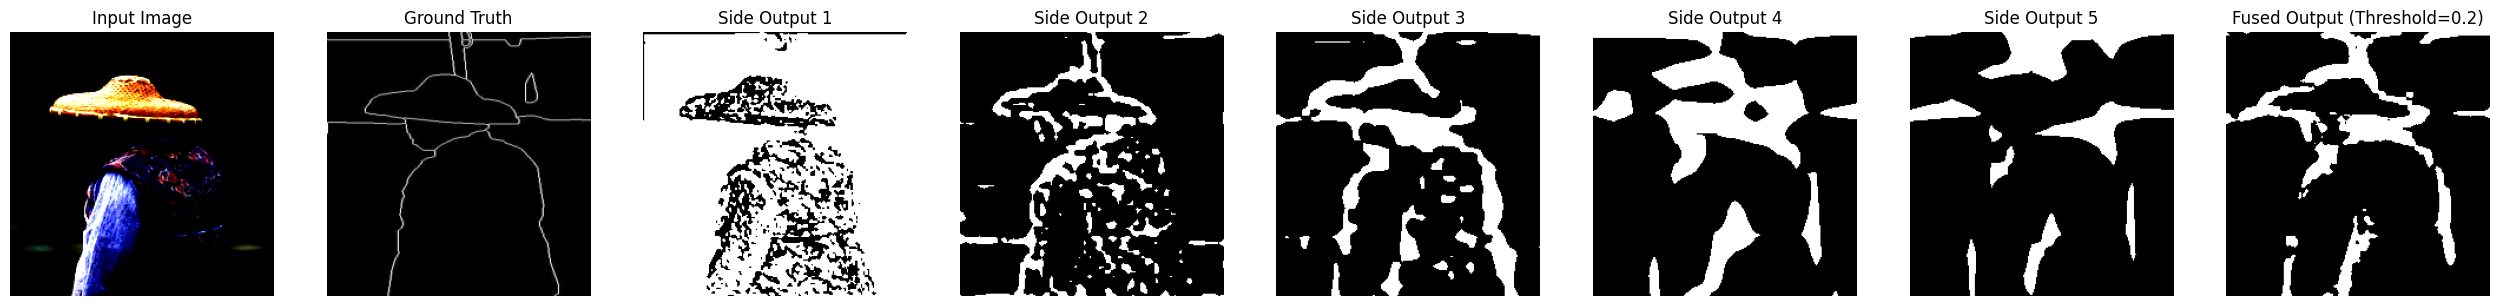

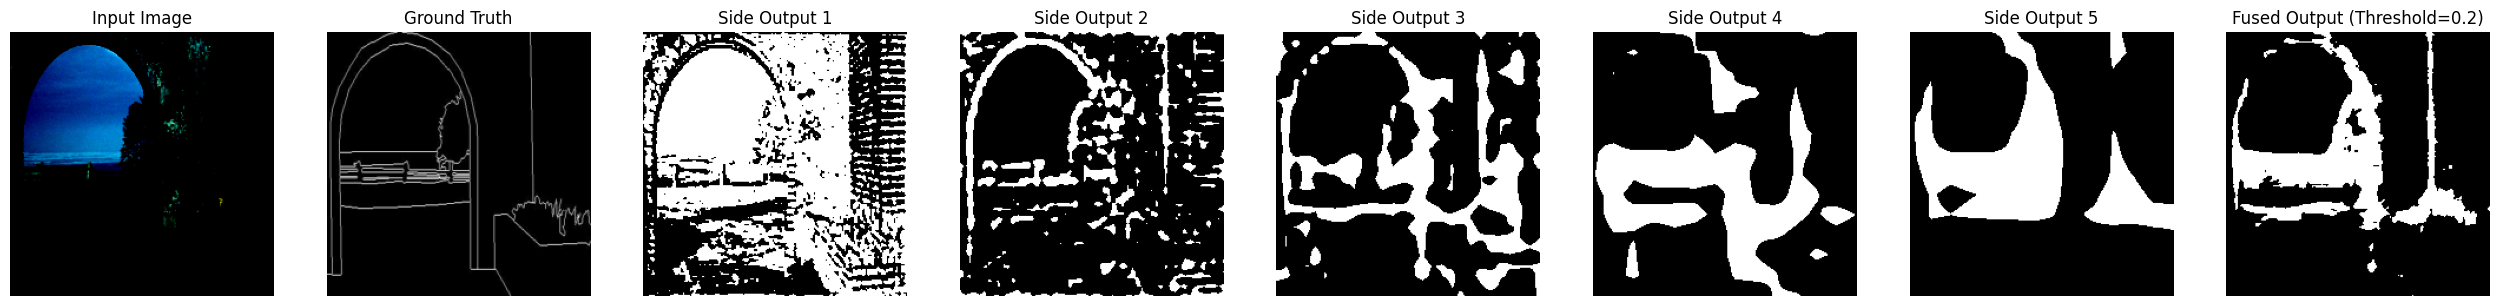

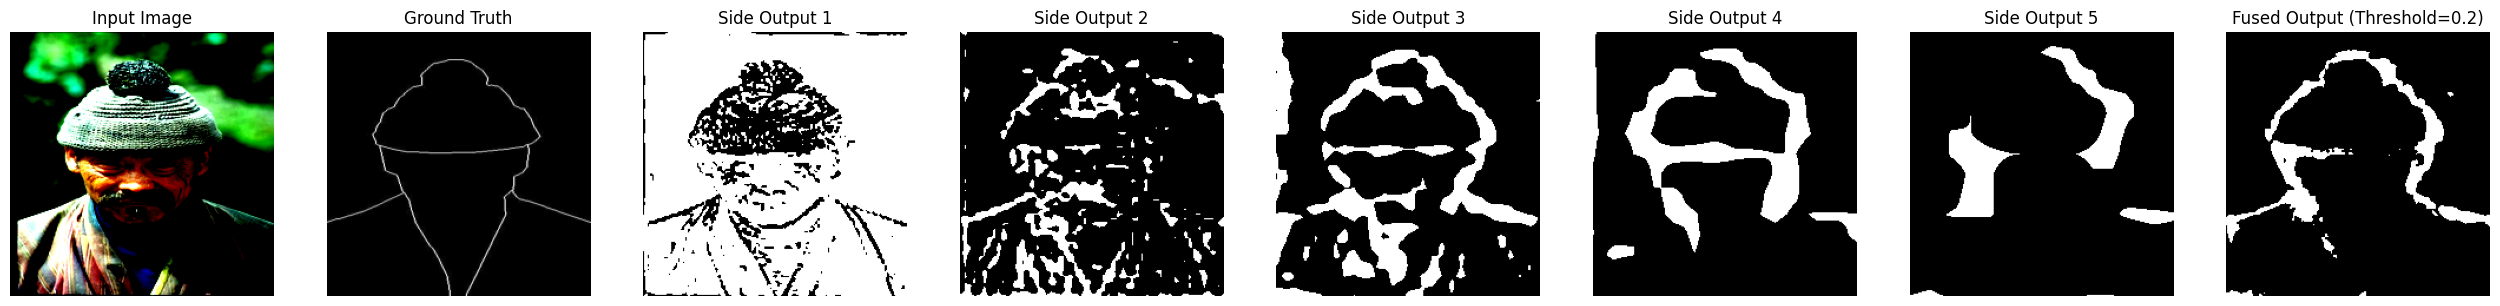

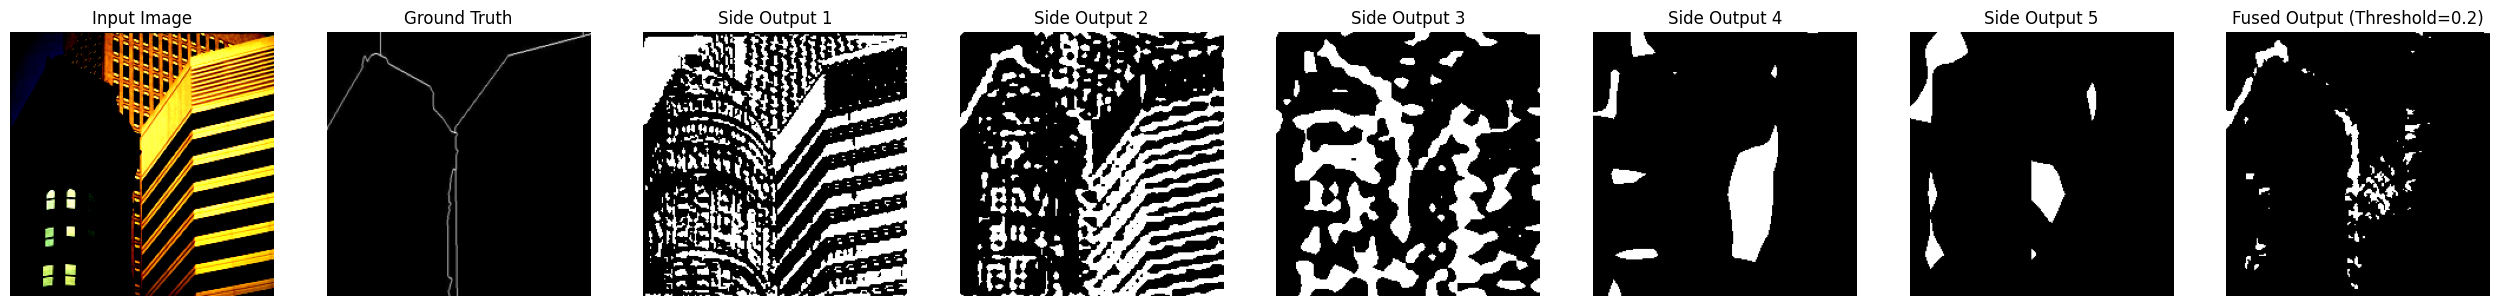

In [18]:
plot_results(model, test_loader, threshold=0.2, device='mps', num_batches=2)